# Set-up 

Codice testato su Python 3.10.11

In [26]:
!python3 -V

Python 3.10.11


Creazione virtual environment

In [ ]:
!python3 -m venv .venv_quantum

Attivazione venv

In [ ]:
!source .venv_quantum/bin/activate #(su MAC)

In [ ]:
!.venv_quantum\Scripts\activate #(su Windows)

Installazione librerie

In [ ]:
!pip3 install -r requirements.txt

# Algoritmi Quantistici

## Stato di Bell ed effetto del rumore

Gli stati di Bell, o coppie EPR, sono quattro stati quantistici di due qubit che rappresentano gli esempi più semplici di entanglement quantistico. Sono definiti come segue:
$$
\begin{aligned}
|\Phi^+\rangle &= \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)\\
|\Phi^-\rangle &= \frac{1}{\sqrt{2}} \left( |00\rangle - |11\rangle \right) \\
|\Psi^+\rangle &= \frac{1}{\sqrt{2}} \left( |01\rangle + |10\rangle \right) \\
|\Psi^-\rangle &= \frac{1}{\sqrt{2}} \left( |01\rangle - |10\rangle \right)
\end{aligned}
$$

Questi stati formano una base ortonormale nel sottospazio di Hilbert a due qubit e sono massimamente entangled. La loro importanza risiede nel fatto che la misurazione di uno dei qubit determina istantaneamente lo stato dell'altro, indipendentemente dalla distanza tra di essi.

Per generare lo stato di Bell $|\Phi^+\rangle$, si parte dallo stato iniziale $|00\rangle$ e si applicano le seguenti operazioni:

1. **Porta Hadamard** sul primo qubit:
   $$
   H|0\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right)
   $$
2. **Porta CNOT** con il primo qubit come controllo e il secondo come target:
   $$
   \text{CNOT} \left( \frac{1}{\sqrt{2}} \left( |00\rangle + |10\rangle \right) \right) = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
   $$
Il risultato finale è lo stato di Bell $|\Phi^+\rangle$:
$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$
---


### Esempio applicativo

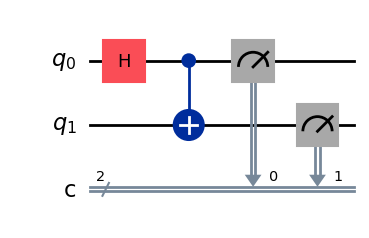

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Circuito per generare lo stato di Bell
bell_circuit = QuantumCircuit(2, 2)
bell_circuit.h(0)          # Hadamard sul primo qubit
bell_circuit.cx(0, 1)      # CNOT: crea entanglement
bell_circuit.measure([0, 1], [0, 1])
bell_circuit.draw('mpl')

Risultati su simulatore ideale:


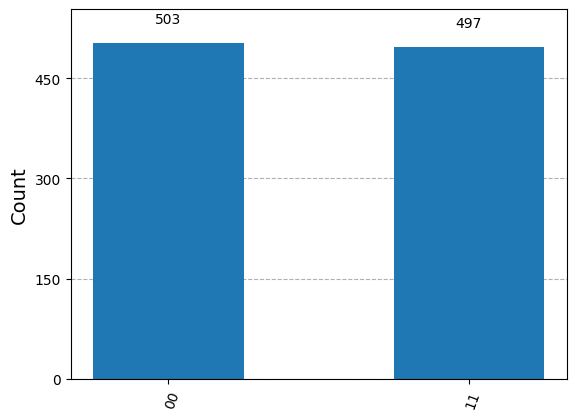

In [2]:
# Simulatore ideale (senza rumore)
simulator_ideal = Aer.get_backend('aer_simulator')
bell_circuit_ideal = transpile(bell_circuit, simulator_ideal)
result_ideal = simulator_ideal.run(bell_circuit_ideal, shots=1000).result()
counts_ideal = result_ideal.get_counts()

print("Risultati su simulatore ideale:")
plot_histogram(counts_ideal)

Risultati su simulatore con rumore:


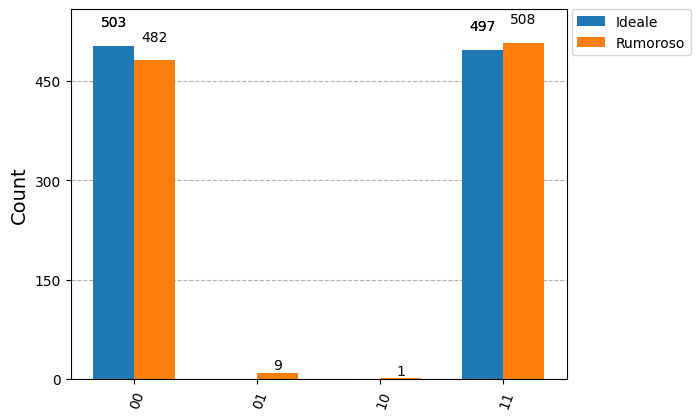

In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.noise import NoiseModel

# Crea un modello di rumore semplice
noise_model = NoiseModel()

# Depolarizing error per porte a 1 e 2 qubit
error_1q = depolarizing_error(0.01, 1)  # 1% errore su 1 qubit
error_2q = depolarizing_error(0.02, 2)  # 2% errore su 2 qubit

# Assegna errori alle porte
noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# Simulatore con rumore
simulator_noisy = Aer.get_backend('aer_simulator')
bell_circuit_noisy = transpile(bell_circuit, simulator_noisy)
result_noisy = simulator_noisy.run(
    bell_circuit_noisy,
    noise_model=noise_model,
    shots=1000
).result()
counts_noisy = result_noisy.get_counts()

# Mostra i risultati
print("Risultati su simulatore con rumore:")
plot_histogram([counts_ideal, counts_noisy], legend=['Ideale', 'Rumoroso'])

## Algoritmo di Deutsch-Jozsa

L’algoritmo di Deutsch-Jozsa è uno dei primi esempi di algoritmo quantistico che mostra un vantaggio esponenziale rispetto agli algoritmi classici. L’obiettivo è determinare se una funzione booleana:

$$
f : \{0,1\}^n \rightarrow \{0,1\}
$$

è:

- **Costante**: restituisce lo stesso output per tutti gli input, oppure  
- **Bilanciata**: restituisce 0 per metà degli input e 1 per l’altra metà.

Una macchina classica richiederebbe fino a $ 2^{n-1} + 1 $ valutazioni nel caso peggiore. L’algoritmo quantistico risolve il problema con **una sola** valutazione della funzione $ f $ implementata come **oracolo**.


> ## Passaggi dell'algoritmo (per $ n = 3 $)
>
> ### 1. Inizializzazione
>
> Si parte dallo stato:
>
> $$
> |\psi_0\rangle = |0\rangle^{\otimes 3} \otimes |1\rangle = |000\rangle \otimes |1\rangle
> $$
>
> Dove i primi 3 qubit rappresentano l'input e l'ultimo è l'**ancilla**.
>
> ---
>
> ### 2. Applicazione delle porte Hadamard
>
> Si applica una porta Hadamard a **tutti e 4 i qubit**:
>
> $$
> H^{\otimes 4} (|\psi_0\rangle) = \left( \frac{1}{\sqrt{8}} \sum_{x \in \{0,1\}^3} |x\rangle \right) \otimes \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right)
> $$
>
> Il sistema è ora in una **sovrapposizione uniforme** di tutti gli input, con l'ancilla in $ |-\rangle $.
>
> ---
>
> ### 3. Applicazione dell'oracolo $ U_f $
>
> L'oracolo agisce come segue:
>
> $$
> U_f |x\rangle|y\rangle = |x\rangle |y \oplus f(x)\rangle
> $$
>
> Poiché $ y = \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle) $, il risultato è:
>
> $$
> U_f |\psi\rangle = \sum_{x} \frac{(-1)^{f(x)}}{\sqrt{8}} |x\rangle \otimes \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right)
> $$
>
> L’informazione su $ f(x) $ è ora codificata nella **fase**.
>
> ---
>
> ### 4. Applicazione delle Hadamard sui primi 3 qubit
>
> Si applica nuovamente $ H^{\otimes 3} $ ai soli qubit di input:
>
> $$
> |\psi_3\rangle = H^{\otimes 3} \left( \sum_x \frac{(-1)^{f(x)}}{\sqrt{8}} |x\rangle \right)
> = \sum_{z \in \{0,1\}^3} \left[ \frac{1}{8} \sum_{x} (-1)^{f(x) + x \cdot z} \right] |z\rangle
> $$
>
> - Se $ f $ è **costante**, allora:
>   $$
>   |\psi_3\rangle = |000\rangle
>   $$
> - Se $ f $ è **bilanciata**, allora:
>   $$
>   \text{Ampiezza di } |000\rangle = 0
>   $$
>   e si osservano stati diversi da $ |000\rangle $.
>
> ---
>
> ### 5. Misurazione
>
> Si misura il primo registro (i primi 3 qubit):
>
> - Se il risultato è $ |000\rangle $, la funzione $ f $ è **costante**.
> - Se si ottiene uno **stato qualsiasi diverso da $ |000\rangle $**, $ f $ è **bilanciata**.


### Esempio applicativo

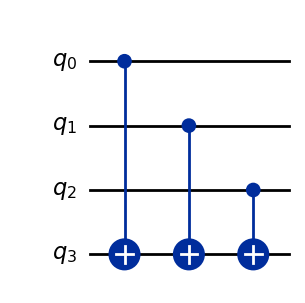

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

def deutsch_jozsa_oracle(n, is_constant=True):
    """Crea l'oracolo Deutsch-Jozsa per una funzione costante o bilanciata"""
    oracle = QuantumCircuit(n + 1)

    if is_constant:
        oracle.x(n)  # Inverte sempre il valore del qubit
    else:
        for i in range(n):
            oracle.cx(i, n)  # Introduce una funzione bilanciata; inverte il valore del qubit solo quando vi è
                # un numero dispari di 1 nella bistring di input

    return oracle

n = 3  # Numero di bit di input
is_constant = False
oracle = deutsch_jozsa_oracle(n, is_constant=is_constant)
oracle.draw('mpl')

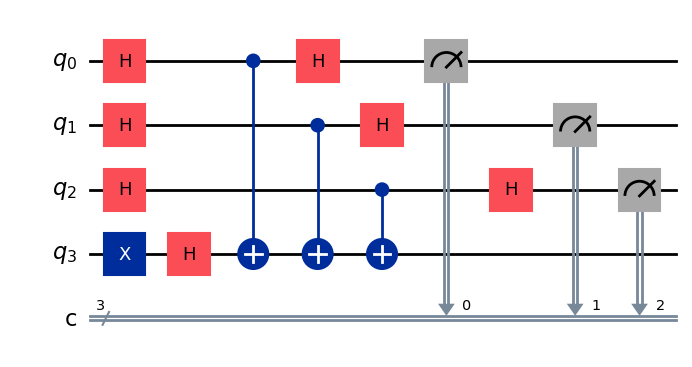

In [5]:
def deutsch_jozsa_algorithm(n, oracle):
    """Implementa l'algoritmo Deutsch-Jozsa per n qubit"""
    # Circuito quantistico con n qubit input e 1 qubit output
    dj_circuit = QuantumCircuit(n + 1, n)

    # Inizializza l'output in |1⟩
    dj_circuit.x(n)
    dj_circuit.h(range(n + 1))

    # Applica l'oracolo
    dj_circuit.compose(oracle, inplace=True)

    # Hadamard sui qubit di input
    dj_circuit.h(range(n))

    # Misura solo i primi n qubit
    dj_circuit.measure(range(n), range(n))

    return dj_circuit

# Crea il circuito
dj_circuit = deutsch_jozsa_algorithm(n, oracle=oracle)
dj_circuit.draw('mpl')

Risultato della funzione: Bilanciata


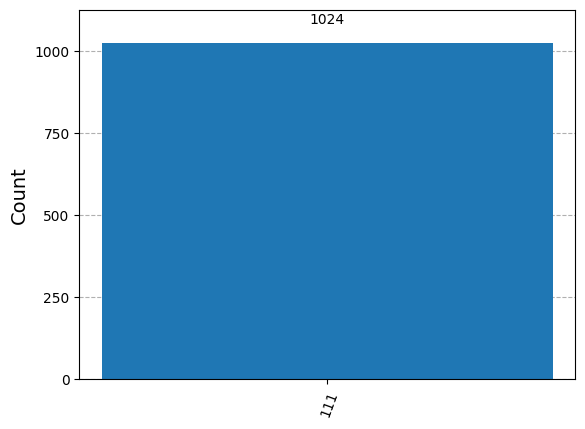

In [6]:
# Simulazione
backend = Aer.get_backend("aer_simulator")
dj_circuit = transpile(dj_circuit, backend)
result = backend.run(dj_circuit, shots=1024).result()
counts = result.get_counts()

# Risultati
print("Risultato della funzione:", "Costante" if is_constant else "Bilanciata")
plot_histogram(counts)

## Algoritmo di Grover

L'algoritmo di Grover è un algoritmo quantistico per la ricerca non strutturata in uno spazio di $ N = 2^n $ elementi, che permette di trovare un elemento marcato $ x^* $ con complessità quadratica $ O(\sqrt{N}) $, rispetto a $ O(N) $ nella ricerca (a forza bruta) classica.


### Obiettivo

Dato un oracolo $ f : \{0,1\}^n \rightarrow \{0,1\} $, che restituisce:

$$
f(x) =
\begin{cases}
1 & \text{se } x = x^* \\
0 & \text{altrimenti}
\end{cases}
$$

l'obiettivo è trovare il valore $ x^* $ con **il minor numero di interrogazioni** dell'oracolo.

---

### Idea Generale

L'algoritmo funziona come una **amplificazione delle probabilità** per lo stato desiderato $ |x^*\rangle $, attraverso due operazioni fondamentali ripetute:

1. **L'oracolo $ U_f $**: inverte il segno dell'ampiezza di $ x^* $,
2. **L'operatore di diffusione**: riflette lo stato corrente rispetto alla media delle ampiezze.

---

### Dettaglio Operativo (per $ n $ qubit)

#### 1. Inizializzazione

Il sistema parte nello stato:

$$
|\psi_0\rangle = |0\rangle^{\otimes n}
$$

Applichiamo Hadamard a tutti i qubit:

$$
H^{\otimes n} |\psi_0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n - 1} |x\rangle
$$

Otteniamo una **sovrapposizione uniforme** di tutti gli stati base.


#### 2. Oracolo $ U_f $

L'oracolo è un'operazione unitaria che inverte il segno dell'ampiezza dello stato $ |x^*\rangle $:

$$
U_f |x\rangle = (-1)^{f(x)} |x\rangle
$$

Questo significa che l'ampiezza di $ |x^*\rangle $ diventa negativa, mentre tutte le altre restano invariate.


#### 3. Operatore di Diffusione $ D $

Il Grover diffusion operator amplifica l'ampiezza del marcatore $ x^* $. È costruito come:

$$
D = 2|\psi_0\rangle \langle\psi_0| - I
$$

In pratica si implementa come:

$$
D = H^{\otimes n} (2|0\rangle \langle 0| - I) H^{\otimes n}
$$

Questa operazione riflette ogni ampiezza rispetto alla media di tutte le ampiezze, e incrementa quella di $ x^* $ a ogni iterazione.

---

#### 4. Iterazioni

Si ripete la combinazione:

$$
G = D \cdot U_f
$$

per circa:

$$
R = \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor
$$

iterazioni, che è il numero ottimale per massimizzare la probabilità di misurare lo stato corretto $ x^* $.

---

#### 5. Misurazione

Dopo le iterazioni, si esegue la **misura** sull'intero registro. Con alta probabilità, il risultato sarà proprio $ x^* $.

![Schema Grover](grovers-iteration.png)

### Esempio applicativo

In [7]:
import math

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import warnings

warnings.filterwarnings(category=DeprecationWarning, action='ignore')

In [8]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Bistring cercate: ['011', '100']


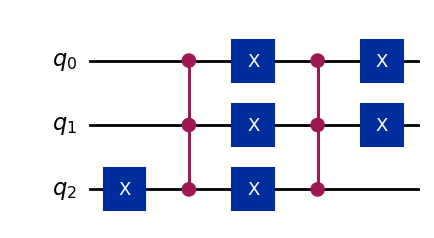

In [9]:
marked_states = ["011", "100"]
# marked_states = ['0']*10
# marked_states[3] = '1'
# marked_states = [''.join(marked_states)]
print('Bistring cercate:', marked_states)

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

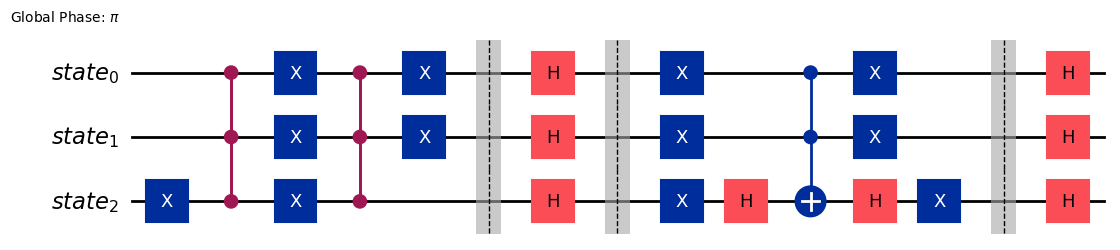

In [10]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw(output="mpl", style="iqp")

Numero ottimale di esecuzioni dell'operatore di Grover: 1


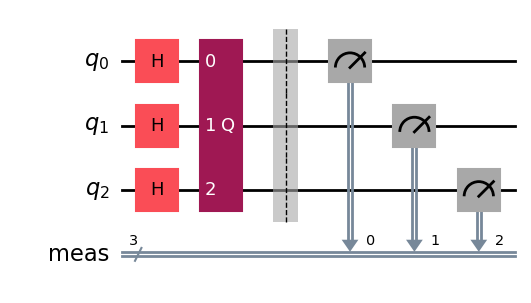

In [14]:
# Si determina il numero ottimale di iterazioni
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )

print("Numero ottimale di esecuzioni dell'operatore di Grover:", optimal_num_iterations)

# optimal_num_iterations = optimal_num_iterations + 1

grover_qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
grover_qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
grover_qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
grover_qc.measure_all()
grover_qc.draw(output="mpl", style="iqp")

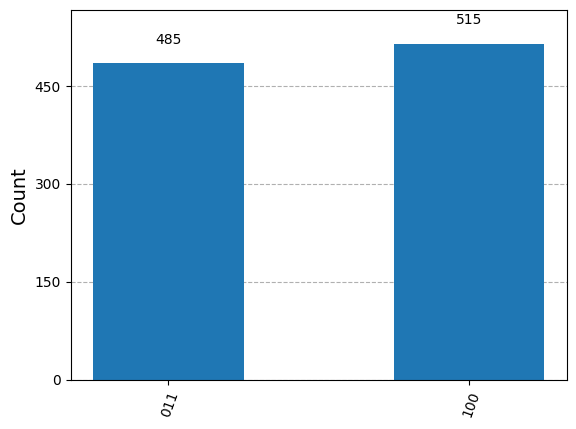

In [15]:
# Simulazione
backend = Aer.get_backend("aer_simulator")
grover_qc = transpile(grover_qc, backend)
result = backend.run(grover_qc, shots=1000).result()
counts = result.get_counts()

# Risultati
plot_histogram(counts)

### Possibile applicazione: 

Una possibile applicazione dell'algoritmo consiste nella risoluzione di problemi di boolean satisfaibility (SAT), ossia quella categoria di problemi per la quale si ricercano uno o più elementi di un insieme di bistring $\vec{x} \in \{0, 1\}^n$ che rispettino vincoli booleani (es. $x_1 \land (x_2 \lor x_3)$). Questa classe di problemi è considerata NP-Hard, e perciò non esiste al momento e probabilmente non verrà mai sviluppato un algoritmo classico per risolvere questi problemi in tempo polinomiale. L'algoritmo di Grover promette uno speed-up quadratico rispetto all'approccio brute-force. 

In questo [paper](https://www.iccs-meeting.org/archive/iccs2021/papers/127470015.pdf) viene presentato un algoritmo di Grover per risolvere il problema di "Spacecraft On-Call Scheduling". Questo problema logistico di tipo SAT consiste nell'assegnare i turni di lavoro per un determinato orizzonte temporale ad un insieme di operatori del German Space Operating Center. Tale assegnazione è sottoposta ad una serie di vincoli i quali rendono la creazione del programma di lavoro non banale. Progettando l'oracolo dell'operatore di Grover in modo da tenere conto di questi vincoli, si è in grado di risolvere il problema ottenendo un quantum advantage.

## Quantum Fourier Transform

La Quantum Fourier Transform (QFT) è la versione quantistica della trasformata di Fourier discreta (DFT). Dato uno stato quantistico a $n$ qubit rappresentato da:

$$
\left| \psi \right\rangle = \sum_{x=0}^{2^n - 1} a_x \left| x \right\rangle,
$$

la QFT applica la trasformata di Fourier sul registro quantistico:

$$
\text{QFT} \left| x \right\rangle = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n - 1} e^{2\pi i x y / 2^n} \left| y \right\rangle.
$$

Operando linearmente sull'intera sovrapposizione:

$$
\text{QFT} \left( \sum_{x=0}^{2^n - 1} a_x \left| x \right\rangle \right) = \sum_{x=0}^{2^n - 1} a_x \, \text{QFT} \left| x \right\rangle.
$$


Il circuito QFT per $n$ qubit è composto da:

  - Porte Hadamard ($H$)
  - Rotazioni di fase controllate ($R_k$)
  - Inversione dell'ordine dei qubit (swap)

### Esempio di funzionamento per 3 qubit

Sia lo stato iniziale $|x_0 x_1 x_2\rangle$. Il circuito applica:


- Sul qubit 0 (più significativo):
  
    - $H$
    - $R_2$: fase $e^{2\pi i / 4}$ (controllata dal qubit 1)
    - $R_3$: fase $e^{2\pi i / 8}$ (controllata dal qubit 2)

- Sul qubit 1:
  
    - $H$
    - $R_2$: fase $e^{2\pi i / 4}$ (controllata dal qubit 2)

- Sul qubit 2:
  
    - $H$

- Swap dei qubit 0 e 2 per invertire l'ordine.


Ogni rotazione controllata di fase è definita come:

$$
R_k = \begin{bmatrix}
1 & 0 \\
0 & e^{2\pi i / 2^k}
\end{bmatrix}
$$

### Esempio applicativo 

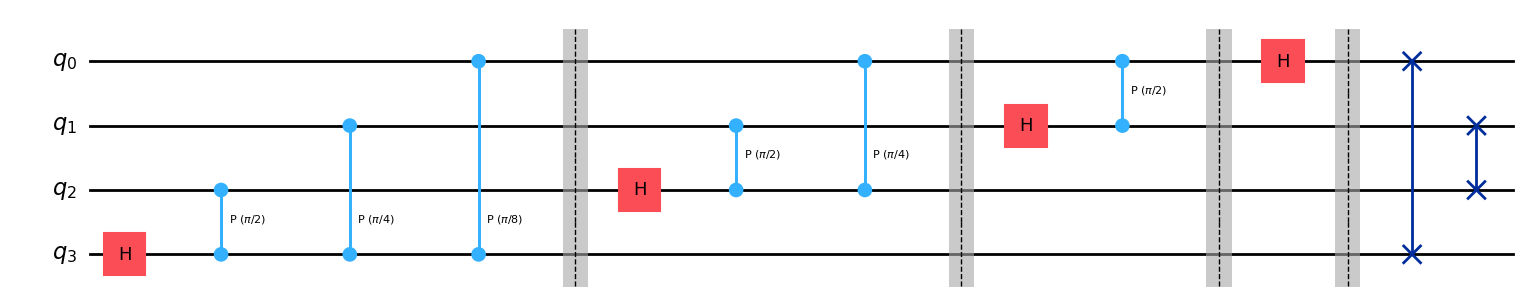

In [124]:
from qiskit.circuit.library import QFT

#definiamo la quantum fourier transform
n_qubits = 4
qft = QFT(n_qubits, insert_barriers=True)
qft.decompose(reps=1).draw('mpl')

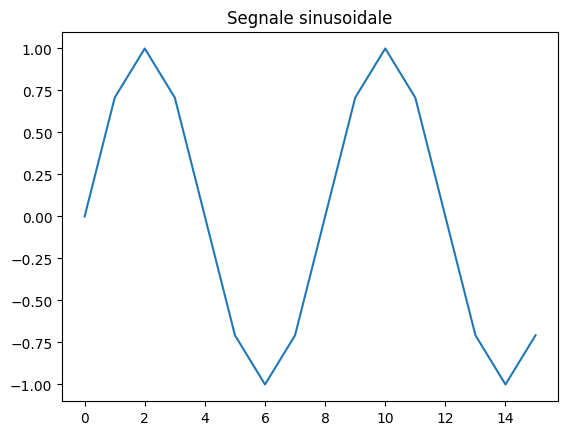

In [134]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# definiamo un segnale sinusoidale
N = 2**n_qubits
x = np.arange(N)
frequency = 2
signal = np.sin(2 * np.pi * frequency * x / N)

# frequency = 5
# signal += np.sin(2 * np.pi * frequency * x / N)

plt.plot(signal)
plt.title('Segnale sinusoidale');

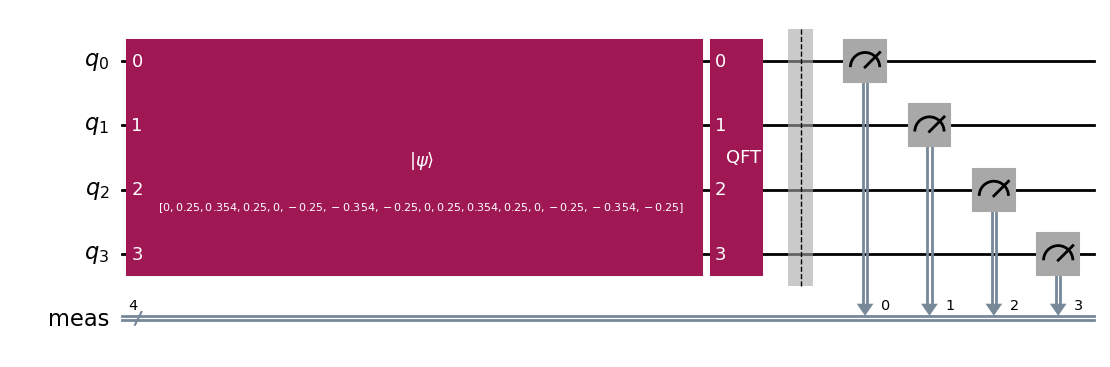

In [135]:
# normalizziamo il segnale per usarlo come ampiezze
norm = np.linalg.norm(signal)
amplitudes = signal / norm

# creiamo lo stato iniziale con amplitude encoding
sv = Statevector(amplitudes)

# costruiamo il  circuito per inizializzare lo stato
qc = QuantumCircuit(n_qubits)
qc.initialize(sv.data, qc.qubits)

# aggiungiamo la quantum fourier transform
qc.compose(qft, inplace=True)
qc.measure_all()

qc.draw('mpl')

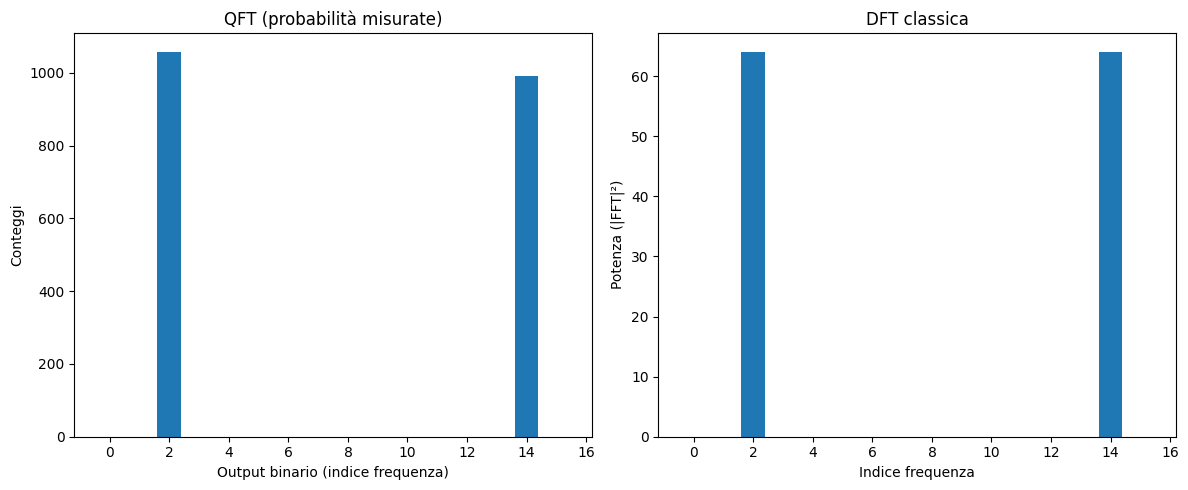

In [136]:
backend = Aer.get_backend("qasm_simulator")
shots = 2048
qc = transpile(qc, backend=backend)
result = backend.run(qc, shots=shots).result()
counts = result.get_counts()

dft_classical = np.fft.fft(signal)
dft_magnitudes = np.abs(dft_classical)**2
dft_magnitudes

counts_ordered = {k: counts.get(k, 0) for k in sorted(counts.keys(), key=lambda b: int(b, 2))}

# Plot QFT e DFT
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# QFT quantistica (misurazioni)
axes[0].bar(range(N), [counts_ordered.get(format(i, '0{}b'.format(n_qubits)), 0) for i in range(N)])
axes[0].set_title("QFT (probabilità misurate)")
axes[0].set_xlabel("Output binario (indice frequenza)")
axes[0].set_ylabel("Conteggi")

# DFT classica (magnitudine al quadrato)
axes[1].bar(range(N), dft_magnitudes)
axes[1].set_title("DFT classica")
axes[1].set_xlabel("Indice frequenza")
axes[1].set_ylabel("Potenza (|FFT|²)")

plt.tight_layout()
plt.show()

## Quantum Phase Estimation

La Quantum Phase Estimation (QPE) è un algoritmo quantistico utilizzato per stimare la fase $\phi$ associata a un autovalore di un operatore unitario $U$, dato il corrispondente autovettore $|\psi\rangle$, tale che:
$$
U|\psi\rangle = e^{2\pi i \phi} |\psi\rangle
$$
La stima della fase è essenziale per algoritmi quantistici più complessi, come l'algoritmo di Shor, ed è per questo che solitamente la QPE viene utilizzata come subroutine all'interno di essi.

### Schema dell'Algoritmo:

Si utilizzano due registri quantistici:
- Un registro di $n$ qubit (registro di controllo), inizializzati in $|0\rangle^{\otimes n}$
- Un qubit target, inizializzato nello stato $|\psi\rangle$

Si applica la porta Hadamard $H$ a ciascun qubit del registro di controllo:
$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} |k\rangle
$$

Si applicano le porte $U^{2^j}$ in modo controllato a ciascun qubit del registro di controllo:
$$
CU^{2^j} \text{ per ogni qubit } j = 0,\dots,n-1
$$
Si esegue la Trasformata di Fourier Quantistica Inversa sul registro di controllo.

Si misura il registro di controllo. L’output sarà una stima binaria di $\phi$ con $n$ bit di precisione.

### Esempio:

Ricerchiamo la fase di questa unitaria di rotazione:
$$
RZ(\phi) = \exp\left(-i\frac{\phi}{2}Z\right) =
            \begin{pmatrix}
                e^{-i\frac{\phi}{2}} & 0 \\
                0 & e^{i\frac{\phi}{2}}
            \end{pmatrix}
$$
In particolare, per $\phi=\pi/2$, otteniamo:
$$
RZ(\pi/2) = \begin{pmatrix}
                e^{-i\frac{\pi}{4}} & 0 \\
                0 & e^{i\frac{\pi}{4}}
            \end{pmatrix}
$$
Questa matrice ha due autovalori, $e^{-i\frac{\pi}{4}}$ e $e^{i\frac{\pi}{4}}$. L'autovalore $e^{-i\frac{\pi}{4}}$ dell'autovettore $|0\rangle$, con fase $\varphi=-\frac{\pi}{4}$, se ricercato attraverso l'algoritmo di QPE, ritornerà il valore:
$$
-\frac{\pi}{4\cdot2\pi} = -\frac{1}{8} \rightarrow  -\frac{1}{8} \mod 1 = \frac{7}{8} = 0.875
$$
Per l'autovalore $e^{i\frac{\pi}{4}}$ dell'autovettore $|1\rangle$, avremo invece:
$$
\frac{\pi}{4\cdot2\pi} = \frac{1}{8} = 0.125
$$

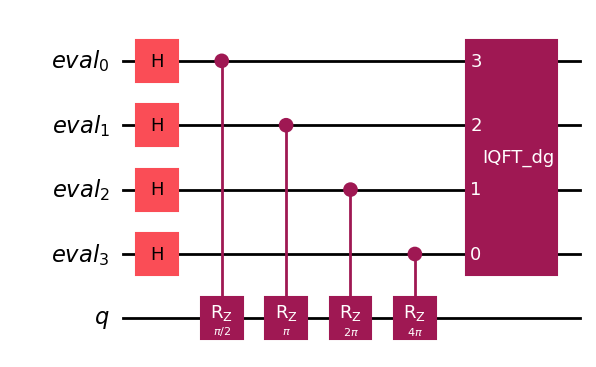

In [16]:
from qiskit.circuit.library import RZGate, XGate
from qiskit_algorithms import PhaseEstimation
from qiskit.primitives import Sampler
import warnings
import numpy as np

warnings.filterwarnings(category=DeprecationWarning, action='ignore')

num_qubits = 4
pe = PhaseEstimation(num_evaluation_qubits=num_qubits, sampler=Sampler())

# Definiamo φ = 1/4 => U = Rz(2π * φ)
unitary = RZGate(2 * np.pi * 1/4)

pe_qc = pe.construct_circuit(unitary=unitary, state_preparation=None) #XGate()
pe_qc.decompose(reps=1).draw('mpl')

In [17]:
result = pe.estimate_from_pe_circuit(pe_qc)
phase = result.phase
binary_string = list(result.phases.keys())[0]
print('Fase trovata:', phase)
print('Stringa corrispondente', binary_string)

Fase trovata: 0.875
Stringa corrispondente 1110


## Algoritmo di Shor

L'algoritmo di Shor rappresenta uno dei più noti algoritmi quantistici. La sua ideazione, dovuta al matematico inglese Peter Shor negli anni '90, ha conferito una spinta propulsiva notevole al settore del quantum computing, dimostrando il notevole impatto che questa tecnologia può avere sul mondo. 

Dato un numero intero arbitrario $ N $, l'algoritmo di Shor mira a trovare i suoi fattori non banali (diversi da 1 e $ N $) in tempo polinomiale, e cioè i numeri interi $p$ e $q$ tali per cui $N=p\cdot q$. Il problema della fattorizzazione di un numero intero è sempre stato considerato irrisolvibile in tempo polinomiale tramite la computazione classica, e perciò sono stati sviluppati dei metodi crittografici asimmetrici, come l'RSA, che basano la propria sicurezza proprio sull'assunzione che un possibile malintenzionato in ascolto su un canale di comnuicazione non sia in grado di risalire alla chiave crittografica privata di un soggetto risolvendo questo problema. L'algoritmo di Shor ha dimostrato la non affidabilità di queste tecniche crittografiche nel lungo termine, ed ha portato allo sviluppo di metodi alternativi resistenti ad attacchi informatici di tipo quantum, riuniti sotto il nome di post-quantum criptography.

### Obbiettivo

Scelto un numero $a<N$, l'algoritmo riduce il problema della fattorizzazione a quello della determinazione del periodo della funzione
$$
f(x) = a^x \mod N,
$$
che può essere risolto efficientemente con un algoritmo quantistico usando come sub-routine la Trasformata di Fourier Quantistica (QFT).

### Passaggi chive dell'algoritmo

- Si sceglie un numero casuale $ a \in [2, N-1] $. Se $ \gcd(a, N) \neq 1 $, allora si è già trovato un fattore non banale di $ N $.
    
-  Si cerca il più piccolo intero positivo $ r $ tale che
    $$
    a^r \equiv 1 \mod N.
    $$
    Questo valore $ r $ è detto il periodo della funzione $ f(x) $.
    
- Se $ r $ è pari e $ a^{r/2} \not\equiv - 1 \mod N $, allora almeno uno dei seguenti è un fattore non banale di $ N $:
    $$
    \gcd(a^{r/2} - 1, N), \quad \gcd(a^{r/2} + 1, N).
    $$
    Se nessuno di essi fornisce un fattore valido, si ripete l'algoritmo con un nuovo valore di $ a $.

### Ricerca del periodo $a^r \equiv 1 \mod N$

- Si preparano due registri quantistici:

    - Registro 1: una sovrapposizione di tutti i $ x \in [0, Q) $, con $ Q = 2^n $, per $ n > \log_2(N^2) $.
    - Registro 2: inizializzato nello stato $ |0\rangle $.

- Si implementa la funzione $ f(x) = a^x \mod N $ sul secondo registro attraverso degli operatori.
    
- Si applica la Trasformata di Fourier Quantistica (QFT) al primo registro.
    
- Si misura il primo registro, ottenendo un valore correlato al periodo $ r $.
    
- Si utilizza un algoritmo classico di frazioni continue (Continued Fractions) per stimare $ r $.

### Esempio

Si voglia fattorizzare $ N = 15 $.


- Scegliamo $ a = 7 $, e $ \gcd(7, 15) = 1 $.
- Troviamo il periodo $ r $ tale che $ 7^r \mod 15 = 1 $. Si ottiene $ r = 4 $.
- Calcoliamo:
    $$
    \gcd(7^{2} - 1, 15) = \gcd(48, 15) = 3, \quad \gcd(7^{2} + 1, 15) = \gcd(50, 15) = 5.
    $$
- Quindi, $ 15 = 3 \times 5 $ è la fattorizzazione trovata.

![Shor circuit](shor.png)

# QAOA per l'Antenna Placement Problem

## Introduzione

Per quanto riguarda gli algoritmi digitali, il più noto e citato metodo per la risoluzione di problemi di ottimizzazione combinatoria è sicuramente il Quantum Approximate Optimization Algoritm (QAOA).
L'obiettivo del QAOA è approssimare lo stato fondamentale (cioè lo stato proprio a energia più bassa) di una data Hamiltoniana del sistema utilizzando un worflow ibrido quantistico-classico. Mappando opportunamente un problema di ottimizzazione del mondo reale in una formulazione Hamiltoniana, il QAOA può essere impiegato per risolvere compiti di ottimizzazione combinatoria.

Per raggiungere questo obiettivo, l'algoritmo richiede la definizione di due Hamiltoniane fondamentali:

- L'Hamiltoniana del problema o cost Hamiltonian, indicata con $ H_C $, che codifica la funzione obiettivo da minimizzare (o massimizzare).
- L'Hamiltoniana di mixing, indicata con $ H_M $, pensata per essere facilmente implementabile tramite gate quantistici e il cui stato fondamentale è noto a priori.

La definizione di queste due Hamiltoniane è motivata dal tentativo dell'algoritmo QAOA di approssimare in modo discreto un'evoluzione adiabatica del sistema di qubit, che è un processo analogico. Quest'ultimo, che è alla base del funzionamento ad esempio di altre tecnologie quantistiche, come i quantum annealer, si basa sul teorema adiabatico, il quale recita:

> ### **Teorema Adiabatico Quantistico**
>
> Se un sistema quantistico si trova inizialmente nello stato fondamentale di un’Hamiltoniana $ H(0) $, e questa Hamiltoniana viene **modificata lentamente** nel tempo verso una nuova Hamiltoniana $ H(T) $, allora, considerati alcuni vincoli, 
> il sistema **rimarrà nello stato fondamentale** dell’Hamiltoniana istantanea $ H(t) $ in ogni momento $ t $, e in particolare si troverà **nello stato fondamentale di $ H(T) $** al termine dell’evoluzione dettata dell'equazione di Schrodinger:
> $$
> i \hbar \frac{\partial}{\partial t} |\psi(t)\rangle = H(t) |\psi(t)\rangle
> $$


Riprendendo quest'ultima definizione, se siamo in grado di preparare il nostro sistema di qubit nello stato fondamentale dell'Hamiltoniana di mixing $ H_M $, al quale il sistema è completamente soggetto al tempo $ t=0 $, ed evolviamo il sistema in modo tale che l'effetto dell'Hamiltoniana di costo $ H_C $ diventi progressivamente dominante rispetto a $ H_M $, allora, alla fine del processo, quando $ H_C $ sarà l'unica Hamiltoniana che agisce sul sistema, il sistema si troverà nel suo stato fondamentale.

Per replicare l’evoluzione analogica del sistema in maniera digitale, cioè tramite operazioni discrete sui qubit mediante gate quantistici, l’algoritmo QAOA propone un approccio euristico basato sull'applicazione alternata di due unitarie parametrizzate:
$$
U_C(\gamma) = e^{-i\gamma H_C}, \quad U_M(\beta) = e^{-i\beta H_M}
$$
Questi operatori unitari sono costruiti a partire dalle definizioni dell'Hamiltoniana di costo $ H_C $ e dell'Hamiltoniana di mixing $ H_M $. Una volta scelto il numero di layer $ p $, che rappresenta un iperparametro del problema, si applicano sequenzialmente $ p $ coppie di $ U_C(\gamma) $ e $ U_M(\beta) $, ottenendo il circuito quantistico che produce lo stato finale:
$$
\ket{\psi_p} = \left( \prod_{j=1}^{p} e^{-i\beta_j H_M} e^{-i\gamma_j H_C} \right) \ket{\psi_0}
$$
dove $ \ket{\psi_0} $ rappresenta lo stato iniziale dei qubit. A questo punto, si valuta l’energia attesa del sistema come
$$
F_p(\vec{\gamma}, \vec{\beta}) = \bra{\psi_p} H_C \ket{\psi_p}
$$
e i parametri $ \{\beta_i, \gamma_i\} $ vengono ottimizzati utilizzando un ottimizzatore classico (ad esempio, gradient-based) al fine di massimizzare la funzione $ F_p(\vec{\gamma}, \vec{\beta}) $. L’obiettivo è trovare i parametri ottimali:
$$
(\vec{\gamma}^*, \vec{\beta}^*) = \arg\max_{\vec{\gamma}, \vec{\beta}} F_p(\vec{\gamma}, \vec{\beta})
$$
che vengono poi utilizzati per sostituire i parametri negli operatori unitari $ U_C(\gamma) $ e $ U_M(\beta) $ del circuito. Dopo un numero sufficiente di iterazioni, questo processo produce uno stato quantistico che corrisponde, o approssima strettamente in energia, lo stato fondamentale del sistema, a seconda dei requisiti del problema specifico affrontato.

![Schema circuito QAOA](qaoa.png)

## Maximum Indipent Set problem

Il problema dell'Antenna Placement presentato in questo [paper](https://arxiv.org/pdf/2205.08500) può essere mappato come un problema di ottimizzazione combinatoria di tipo Maximum Indipendent Set (MIS). 

> ### **Problema del Maximum Independent Set (MIS)**
>
> Dato un grafo non orientato $ G = (V, E) $, un **insieme indipendente** è un sottoinsieme di nodi $ S \subseteq V $ tale che **nessuna coppia di nodi in $ S $** sia collegata da un arco in $ E $. Cioè, per ogni $ (i, j) \in E $, almeno uno tra $ i $ o $ j $ **non** appartiene a $ S $.
>
> Il problema del **Maximum Independent Set** consiste nel trovare un insieme indipendente di **massima cardinalità**:
>
> $$
> \max_{x \in \{0,1\}^n} \left( \sum_{i \in V} x_i \right)
> \quad \text{soggetto a} \quad x_i x_j = 0 \quad \forall (i,j) \in E
> $$
>
> Dove:
> - $ x_i = 1 $ se il nodo $ i $ è incluso nell'insieme indipendente;
> - $ x_i = 0 $ altrimenti.
>
> Nessun arco può collegare due nodi con $ x_i = x_j = 1 $.

L'Hamiltoniana per il problema del Maximum Independent Set (MIS) su un grafo $G = (V, E)$, con penalizzazione $M > 0$, è:

$$
H = -\sum_{i \in V} x_i + M \sum_{(i,j) \in E} x_i x_j
$$

dove $x_i \in \{0, 1\}$ indica se il nodo $ i $ è incluso nell'independent set.


Utilizzando la mappatura quantistica $ x_i = \frac{1 - Z_i}{2} $, otteniamo:

$$
H = -\sum_{i \in V} \frac{1 - Z_i}{2} + M \sum_{(i,j) \in E} \frac{(1 - Z_i)(1 - Z_j)}{4}
$$

## Esempio applicativo

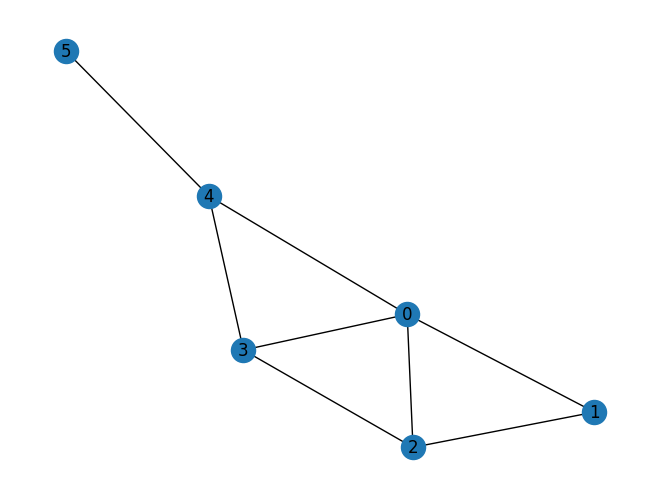

In [18]:
import networkx as nx
import numpy as np
import warnings

from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp, Pauli

warnings.filterwarnings(category=DeprecationWarning, action='ignore')

# 1. Graph Construction
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (4, 0), (4, 3), (4, 5)])
# G = nx.erdos_renyi_graph(10, 0.4)

nx.draw(G, with_labels=True)

In [19]:
# Definizione dell'Hamiltoniana

def get_sparse_mis_hamiltonian(graph: nx.Graph, M=2.0):
    num_nodes = graph.number_of_nodes()
    paulis = []
    coeffs = []

    # Termine -sum_i (1 - Z_i)/2
    for i in range(num_nodes):
        z = ['I'] * num_nodes
        z[i] = 'Z'
        paulis.append(Pauli(''.join(reversed(z))))
        coeffs.append(0.5)  # +0.5 * Z_i
    coeffs.append(-0.5 * num_nodes)  # -0.5 * n * I
    paulis.append(Pauli('I' * num_nodes))

    # Termine M * sum_{(i,j)} (1 - Z_i)(1 - Z_j)/4
    for (i, j) in graph.edges():
        # Z_i * Z_j
        zz = ['I'] * num_nodes
        zz[i] = 'Z'
        zz[j] = 'Z'
        paulis.append(Pauli(''.join(reversed(zz))))
        coeffs.append(M * 0.25)

        # Z_i
        zi = ['I'] * num_nodes
        zi[i] = 'Z'
        paulis.append(Pauli(''.join(reversed(zi))))
        coeffs.append(-M * 0.25)

        # Z_j
        zj = ['I'] * num_nodes
        zj[j] = 'Z'
        paulis.append(Pauli(''.join(reversed(zj))))
        coeffs.append(-M * 0.25)

        # costante
        paulis.append(Pauli('I' * num_nodes))
        coeffs.append(M * 0.25)

    return SparsePauliOp(paulis, coeffs=np.array(coeffs, dtype=np.float64)).simplify()

hamiltonian = get_sparse_mis_hamiltonian(G, M=2)
print(hamiltonian)

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'IIIIII', 'IIIIZZ', 'IIZIIZ', 'IIIZIZ', 'IZIIIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[-1.5+0.j, -0.5+0.j, -1. +0.j, -1. +0.j, -1. +0.j,  1. +0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j])


In [24]:
# 3. QAOA Setup
sampler = Sampler()
qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=4)

In [25]:
# 4. Esecuzione
result = qaoa.compute_minimum_eigenvalue(hamiltonian)

result_dict = result.eigenstate.binary_probabilities()

max_bitstring = max(result_dict, key=lambda x : result_dict[x])

print('maximum probability bitstring:', max_bitstring)
print('probability:', result_dict[max_bitstring])
print('correct bistring probability:', result_dict['101010']) # bitstring soluzione

maximum probability bitstring: 101010
probability: 0.1431466871541109
correct bistring probability: 0.1431466871541109


In [26]:
sum([v for v in result_dict.values()]) #somma delle probabilità

np.float64(1.0000000000000009)

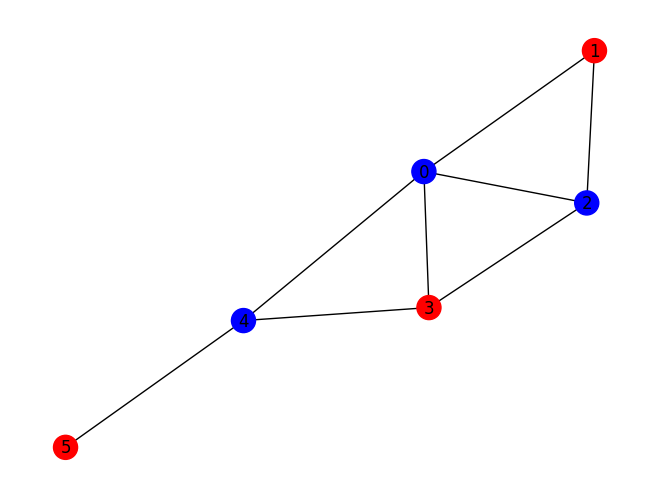

In [27]:
node_colors = ['r' if n=='1' else 'b' for n in max_bitstring]
node_colors.reverse()
nx.draw(G, node_color=node_colors, with_labels=True)

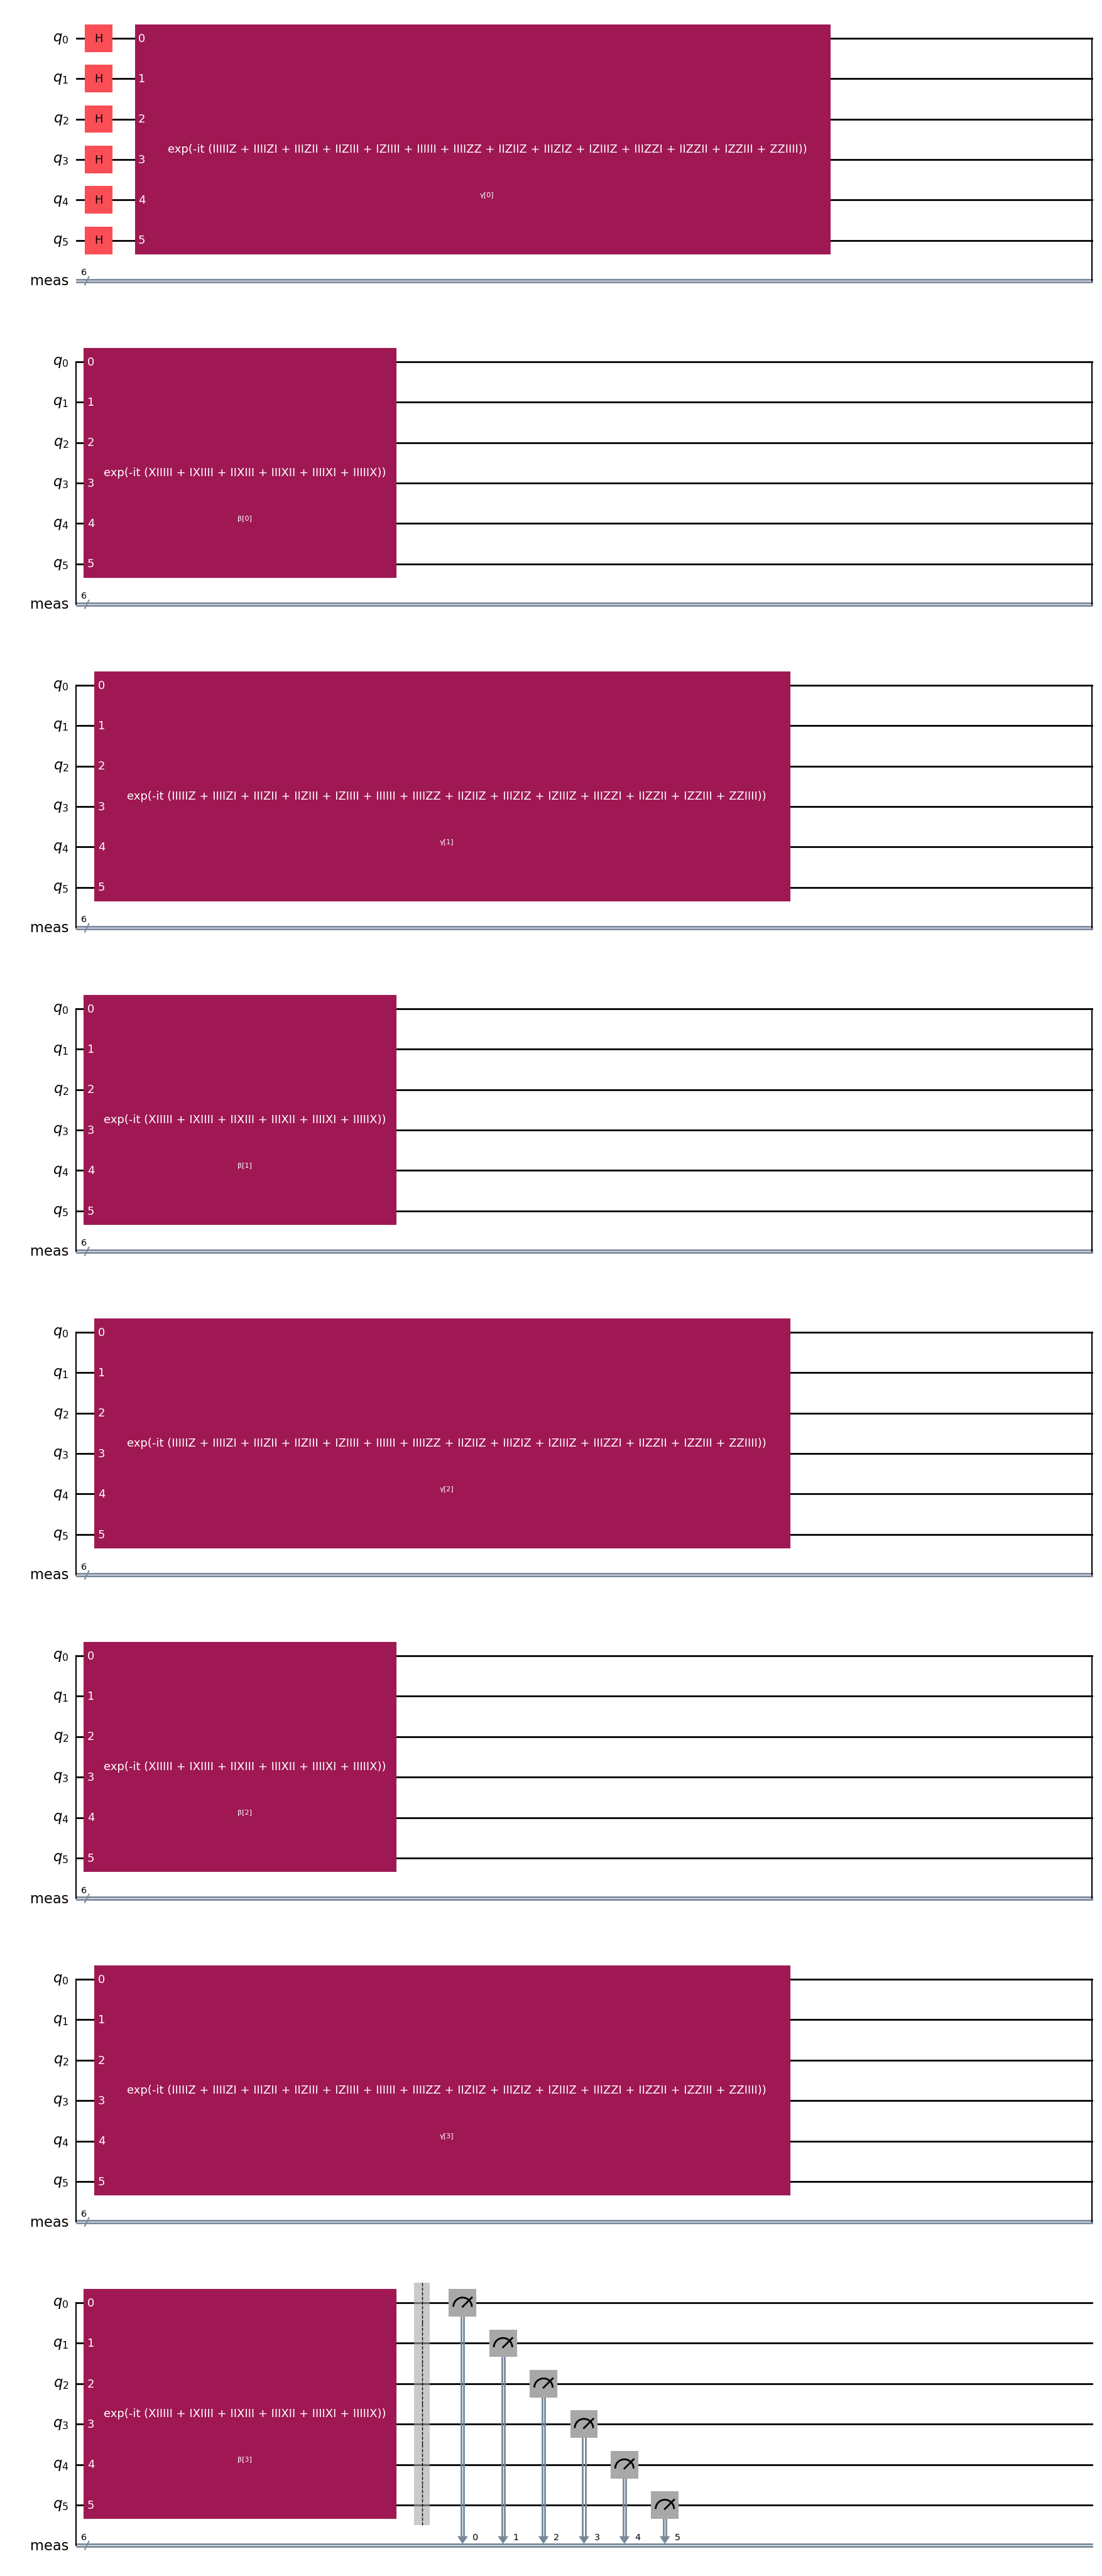

In [28]:
qaoa.ansatz.decompose(reps=0).draw('mpl')

# Approfondimento

Per approfondire il funzionamento degli algoritmi di base presentati in questo notebook, si può consultare gratuitamente il libro di Thomas Wong: [Introduction to Classical and Quantum Computing](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)